In [273]:
from pandas import read_csv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
from sklearn.preprocessing import StandardScaler
from __future__ import division
def parser(x):
    return pd.datetime.strptime('2015'+x, '%Y%d/%m/%H %M')

data = read_csv('./BATADAL_dataset03.csv', header=0, parse_dates=[0], index_col=0, squeeze=True,\
                  date_parser=parser)
data.drop(['ATT_FLAG'],axis=1)
series = data.copy()

In [274]:
import custom_function as cf

In [ ]:
data['L_T3'].mean()

In [276]:
# definition of the different state
x1 = (data['L_T3'] <=3).astype(int)
x2= ((data['L_T3'] > 3) & (data['L_T3']<=3.5)).astype(int)
x3 = ((data['L_T3'] > 3.5) & (data['L_T3']<=4)).astype(int)
x4 = ((data['L_T3'] > 4) & (data['L_T3']<=4.5)).astype(int)
x5 = ((data['L_T3'] > 4.5) & (data['L_T3']<=5)).astype(int)
x6 = (data['L_T3'] >5).astype(int)
df_mm = x1 + 2*x2 + 3*x3 + 4*x4 + 5*x5 + 6*x6



In [277]:
# getting the anomaly labels for our dataset (evaluating sequence of 5 values and anomaly = less than 20% probable)
df_anomaly = cf.markovAnomaly(df_mm, 10, 0.20)
df_anomaly = pd.Series(df_anomaly)
print(df_anomaly.value_counts())

0    8756
1       5
dtype: int64


In [278]:
data['anomaly24'] = df_anomaly

In [279]:
# SAX discritization
from saxpy import SAX
s = SAX(3, 3, 1e-6)
(x3Strings, x3Indices) = s.sliding_window(data['L_T3'], 350, 0.01)
print len(x3Strings)
print len(x3Indices)
print len(set(x3Strings))
#print x3Indices

365
365
3


In [ ]:
X=np.array(range(len(data)))
data.insert(0, 'SAX_value', X)

sax_data=pd.DataFrame(x3Indices,x3Strings )
str_set=set(x3Strings)

print type(str_set)
for i,item in enumerate(str_set):
    start=np.array(sax_data.loc[item][0])
    end=np.array(sax_data.loc[item][1])
    #print item,i
    for j in xrange(len(start)):
        #print j
        data['SAX_value'][range(start[j],end[j])]=i
    

In [ ]:
sax_anomaly = cf.markovAnomaly(data['SAX_value'], 30, 0.20)
sax_anomaly = pd.Series(sax_anomaly)
print(sax_anomaly.value_counts())

# PCA analysis

1.Normalization

In [195]:
my_data=data.drop(['ATT_FLAG'],axis=1)
my_data=my_data.dropna(axis=0,how='any')
X_train = my_data.iloc[:, :].values

#standardize the training data
def standardize(X_train):
    d_list=[]  
    for c in range(X_train.shape[1]):
        x_std=X_train[:,c].std()
        if x_std ==0 :
            d_list.append(c)
        
    train=np.delete(X_train,d_list,axis=1)

    scaler = StandardScaler().fit(train)
    X_train = scaler.transform(train)
    return X_train
X_train=standardize(X_train)

In [196]:
from sklearn.decomposition import PCA
myModel=PCA(n_components=15)
low_data=myModel.fit_transform(X_train)
print X_train.shape

print 'This model captures {:0.0%} of variance'.format(sum(myModel.explained_variance_ratio_))

(8761, 36)
This model captures 99% of variance


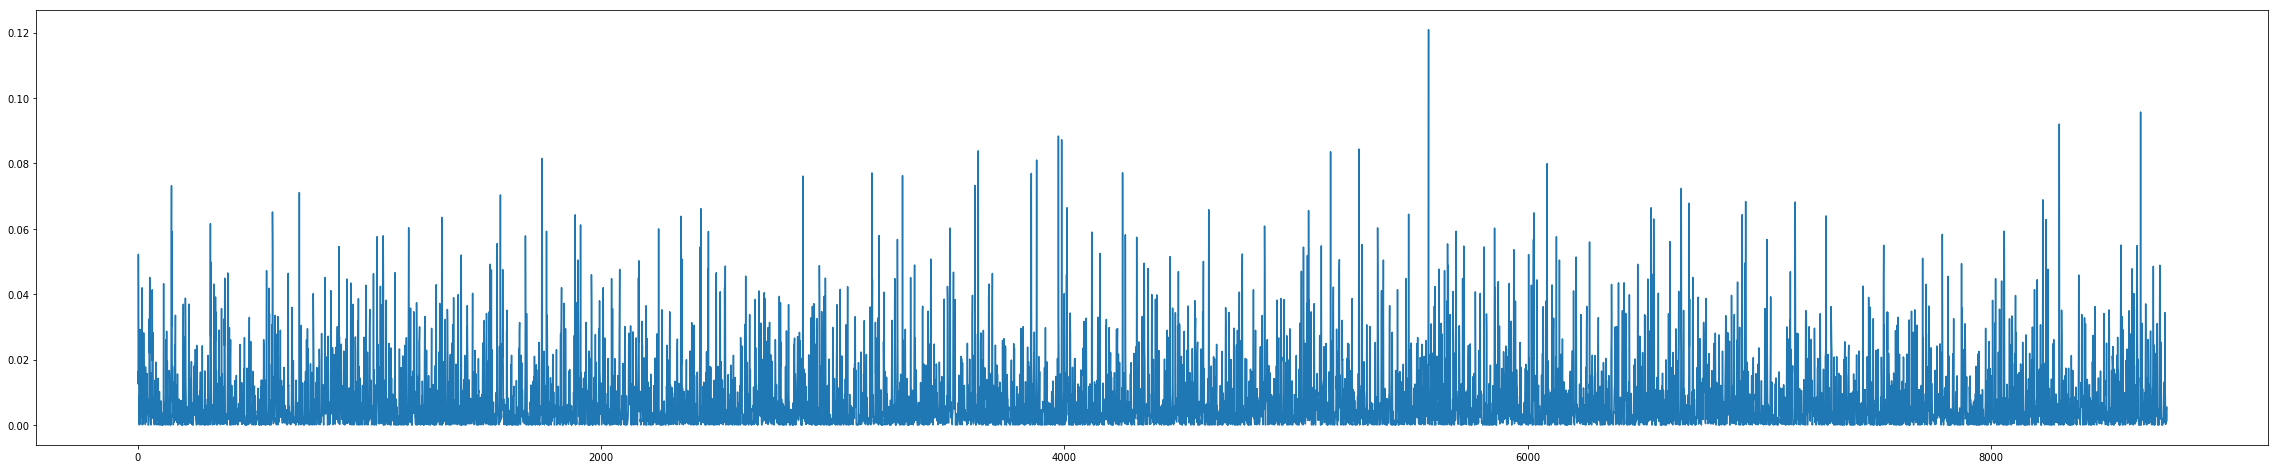

In [197]:
restore_data=myModel.inverse_transform(low_data)
res=np.array(X_train-restore_data)  # compute the residual
signal1=np.square(res[:,2])   # pick one certain signal to visualize the residual

plt.figure(figsize=(40,8))
plt.plot(signal1)


In [189]:
sum(signal1>0.1)

1

# optimize with dataset 2

In [272]:
data2 = read_csv('./BATADAL_dataset04.csv', header=0, parse_dates=[0], index_col=0, squeeze=True,\
                  date_parser=parser)
data2.shape

(4177, 44)

In [271]:
data2=data2.drop([' ATT_FLAG'],axis=1)
my_data2=data2.dropna(axis=0,how='any')
X_val = my_data2.iloc[:, :].values
len(X_val)

4177

In [202]:
X_val=standardize(X_val)

In [203]:
myModel=PCA(n_components=15)
low_data2=myModel.fit_transform(X_val)
print X_train.shape

print 'This model captures {:0.0%} of variance'.format(sum(myModel.explained_variance_ratio_))

(8761, 36)
This model captures 98% of variance


219

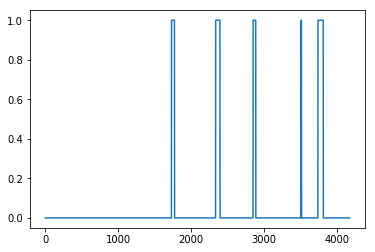

In [217]:
label=data2[data2.columns[-1]]
label=np.array(label+999)/999
plt.plot(label)
sum(label)

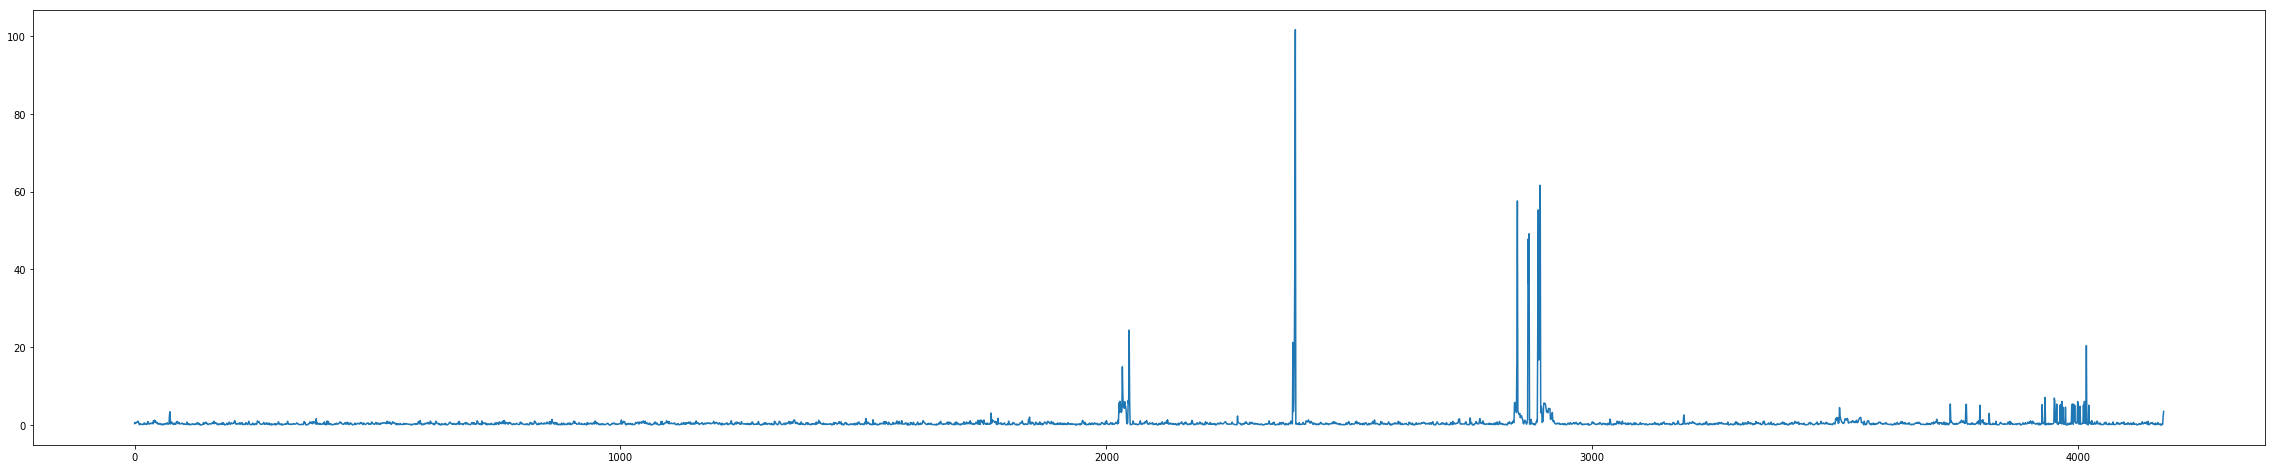

In [233]:
restore_data2 = myModel.inverse_transform(low_data2)
res2 = np.array(X_val-restore_data2)  # compute the residual
residual2 = np.sum(np.square(res2),axis=1)  #compute overall residuals
#signal2 = np.square(res2[:,2])   # pick one certain signal to visualize the residual

plt.figure(figsize=(40,8))
plt.plot(residual2)

In [270]:
len(residual2),len(label)

(4177, 4177)

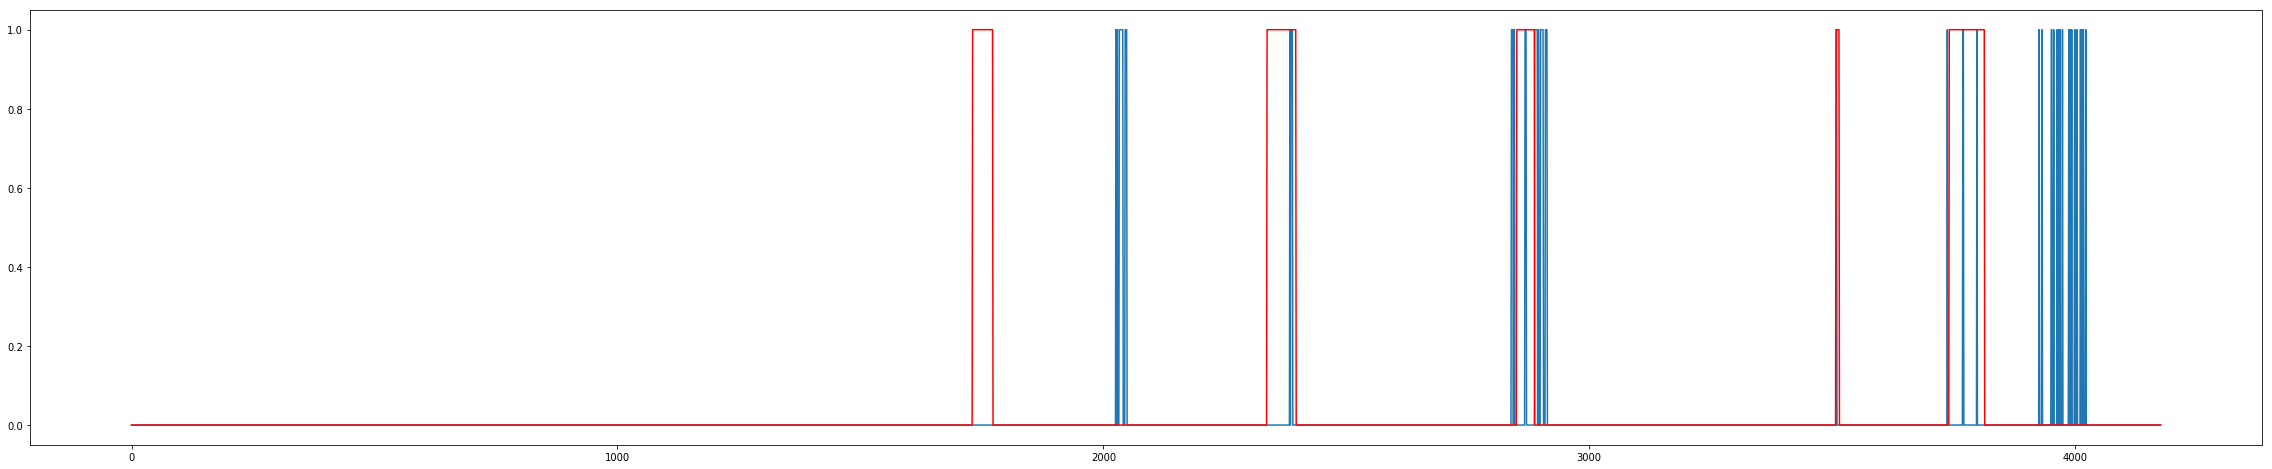

In [268]:
prediction=(residual2>4)*1
plt.figure(figsize=(40,8))
plt.plot(prediction)
plt.plot(label,'r')

In [269]:
from sklearn.metrics import confusion_matrix
#  true negatives  false positives
#  false negatives  true positives
cm=confusion_matrix(label,prediction)

recall = cm[1][1]/(cm[0][1]+cm[1][1])
print recall

0.16


0.1896551724137931